In [261]:
import pandas as pd
import numpy as np
import requests
import statistics
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import random
from sp500_divs import sp500_dividend_yields

In [262]:
# Sandbox Key
api_key = 'OjgyNDVkYzNmMWIyMTdkNzM3YTYzMDc0MzFhM2U2OTY2'

In [260]:
# Production Key
# api_key = 'Ojk0OWQyOTYyOTgxZTU4YzA4MjU5NGFmNjY2MjhhODQ2'

In [135]:
# Retrieve list of all tickers tracked by Intrinio
def get_all_companies():
    next_page = ''
    companies = {}
    while next_page is not None:
        request_url = f'https://api-v2.intrinio.com/companies?api_key={api_key}&page_size=100000&next_page={next_page}'
        content = requests.get(request_url)
        page = content.json()
        comps = page['companies']
        for c in comps:
            companies[c['name']] = c['ticker']
        next_page = page['next_page']
    return companies

In [136]:
# Returns 10 years of values for the specified company and datapoint
def get_data_tenyr(identifier, tag, freq='quarterly'):
    start_date = get_date()
    # Majority of api requests to Intrinio happen here
    request_url = f'https://api.intrinio.com/historical_data?frequency={freq}&identifier={identifier}&item={tag}&api_key={api_key}&start_date={start_date}'
    content = requests.get(request_url)
    return content.json()['data']

In [138]:
# Finds the specific datapoint desired from a 10 year list of data
# Specifiying n also gives the n values preceding
def get_datapoint(data, years_ago, n):
    
    # Find the data point gathered closest to the desired date
    date_yrs_ago = datetime.now() - relativedelta(years=years_ago)
    date_yrs_ago = date_yrs_ago.strftime('%Y-%m-%d')
    target_date = find_closest(date_yrs_ago, data)
    if target_date is None:
        return None
    
    # If data point taken too far from desired date, insuffient data, return None
    yr = datetime.now().year
    target_yr = int(target_date[:4])
    if target_yr not in range(yr - years_ago - 1, yr - years_ago + 2):
        return None
    
    ret = []
    for x in range(n):
        current_target = str(int(target_date[:4]) - x) + target_date[4:]
        current_target_yr = int(current_target[:4])
        closest = find_closest(current_target, data)
        if int(closest[:4]) not in range(current_target_yr, current_target_yr + 2):
            ret += [{'date': current_target, 'value': 'nm'}]
        else:
            ret += [item for item in data if item['date'] == closest]
    
    return ret

In [139]:
# Called during guru analysis to get data for a specific company and datapoint
def get_fundamental(ticker, years_ago, tag, n=1):
    data = get_data_tenyr(ticker, tag)
    return get_datapoint(data, years_ago, n)

In [140]:
# Returns most recent datpoint for specified company and category
def get_current_datapoint(ticker, tag):
    request_url = f'https://api-v2.intrinio.com/companies/{ticker}/data_point/{tag}/number?api_key={api_key}'
    content = requests.get(request_url)
    if content is None:
        print("{} returned none".format(ticker))
    return content.json()

In [141]:
# For a list of dates and values, finds the closest entry to the specified date
def find_closest(date, data):
    if data == []:
        return None
    previous = data[0]['date']
    for item in data:
        current = item['date']
        if is_later(date, current):
            return closer(previous, current, date)
        previous = current
    return current

In [142]:
def ERROR(tag, ticker):
    msg = 'No {} data for company: {}'.format(tag, ticker)
    return msg

In [143]:
# If Intrinio has no data for the company's current net income, cannot run analyses
def is_current(ticker, data=None):
    if data:
        ni = data
    else:
        ni = get_data_tenyr(ticker, 'netincome')
    if not ni:
        return False
    current_year = datetime.today().year
    
    last_filing = int(ni[0]['date'][:4])
    if last_filing == current_year or last_filing == current_year - 1:
        return True
    return False


In [144]:
# Returns date 10 years ago
def get_date():
    date_yrs_ago = datetime.now() - relativedelta(years=10)
    start = date_yrs_ago
    return start.strftime('%Y-%m-%d')


In [145]:
# Given two date strings, convert to datetimes and return whether the first is after the second
def is_later(date1, date2, or_equal=False):
    datetime1 = datetime.strptime(date1, '%Y-%m-%d')
    datetime2 = datetime.strptime(date2, '%Y-%m-%d')
    
    return date1 > date2 if or_equal is False else date1 >= date2

In [146]:
# determines if date1 or date2 is closer to dateTarget
def closer(date1, date2, dateTarget):
    datetime1      = datetime.strptime(date1, '%Y-%m-%d')
    datetime2      = datetime.strptime(date2, '%Y-%m-%d')
    datetimeTarget = datetime.strptime(dateTarget, '%Y-%m-%d')
    dif1 = abs(datetimeTarget - datetime1)
    dif2 = abs(datetimeTarget - datetime2)
    
   
    return date1 if dif1 < dif2 else date2

In [225]:
# Function to return Lynch score
# Based on criteria found here https://www.nasdaq.com/article/peter-lynch-fair-value-value-companies-with-peter-lynchs-simple-rule-of-thumb-cm154990
def lynch_recommends(ticker, years_ago=0):
    PEG_threshold = 1.0
    

    
###### Growth Rate #############################################################
    
    tag = 'netincomegrowth'
    ni_growth = get_fundamental(ticker, years_ago, tag)
    if ni_growth is None:
        return (ERROR(tag, ticker), None)
    
    if isinstance(ni_growth[0]['value'], str):
        growth = 0
    else:
        growth = ni_growth[0]['value']
#         print("Growth is ", growth)
    
    # The date of the quarter used for current_ratio is the date we will use for other datapoints
    quarter_date        = ni_growth[0]['date']
    
    
###### PE Ratio ################################################################
    
    tag = 'pricetoearnings'
    ten_yr_pe_ratios = get_data_tenyr(ticker, tag)
    
    if not is_current(ticker, ten_yr_pe_ratios):
        return ERROR('recent_filing', ticker), None

    pe_date          = find_closest(quarter_date, ten_yr_pe_ratios)
    if pe_date is None:
        return (ERROR(tag, ticker), None)
    pe_ratio         = [item for item in ten_yr_pe_ratios if item['date'] == pe_date][0]['value']
#     print("PE is ", pe_ratio)
    


###### Dividend Rate ############################################################
    
    tag = 'dividendyield'
    ten_yr_dividend_rate = get_data_tenyr(ticker, tag)
    dividend_date        = find_closest(quarter_date, ten_yr_dividend_rate)
    if dividend_date is None:
        return (ERROR(tag, ticker), None)
    dividend_rate        = [item for item in ten_yr_dividend_rate if item['date'] == dividend_date][0]['value']
#     print("Dividend Rate is ", dividend_rate)
    
###### Calculations #############################################################
    # Lynch formula returns 1 if PEG >= 1
    if pe_ratio == 'nm':
        return 0, quarter_date
    appreciation = (growth + dividend_rate) * 100
    if appreciation == 0:
        return 0, quarter_date
    Lynch_ratio = appreciation / pe_ratio
    return (Lynch_ratio, quarter_date)


In [148]:
# Function to return Graham score
# Based on criteria found for Enterprising Investors in The Intelligent Investor by Benjamin Graham 
def graham_recommends(ticker, years_ago=0):
    PE_threshold = 15.0
    current_ratio_threshold = 1.5
    lt_debt_threshold = 1.10
    earnings_threshold = 0.0
    dividend_threshold = 0.0
    earnings_multiple = 1.0
    PB_threshold = 1.4
    
    enterprise_score = 0
    
###### Financial Condition ###################################################
    
    tag = 'currentratio'
    current_ratio       = get_fundamental(ticker, years_ago, tag)
    if current_ratio is None:
        return ERROR(tag, ticker), None
    
    tag = 'nwc'
    net_working_capital = get_fundamental(ticker, years_ago, tag)
    if net_working_capital is None:
        return ERROR(tag, ticker), None
    
    tag = 'longtermdebt'
    longterm_debt       = get_fundamental(ticker, years_ago, tag)
    if longterm_debt is None:
        return ERROR(tag, ticker), None
    
    # The date of the quarter used for current_ratio is the date we will use for other datapoints
    quarter_date        = current_ratio[0]['date']
    
    current_ratio       = current_ratio[0]['value']
    net_working_capital = net_working_capital[0]['value']
    longterm_debt       = longterm_debt[0]['value']
    
    if current_ratio is None or isinstance(current_ratio, str):
        enterprise_score += 0
    else:
        # Current Ratio should not exceed 1.5
        dif = current_ratio_threshold - current_ratio
        dif_pct = dif / current_ratio_threshold
        enterprise_score += min(1, max(1-dif_pct, 0))
    
    if longterm_debt is None or isinstance(longterm_debt, str) or net_working_capital is None or isinstance(net_working_capital, str) or net_working_capital == 0:
        enterprise_score += 0
    else:
        # Longterm debt not to exceed net working capital by more than 1.1x
        debt_ratio = longterm_debt / net_working_capital
        if debt_ratio <= lt_debt_threshold:
            enterprise_score += 1
        else:
            dif = debt_ratio - lt_debt_threshold
            dif_pct = dif / lt_debt_threshold
            enterprise_score += min(1, max(1-dif_pct, 0))

    
###### PE Ratio ################################################################

    tag = 'pricetoearnings'
    ten_yr_pe_ratios = get_data_tenyr(ticker, tag)
    
    # Making sure data exists currently
    if not is_current(ticker, data=ten_yr_pe_ratios):
        return ERROR('recent_filing', ticker), None
       
    pe_date          = find_closest(quarter_date, ten_yr_pe_ratios)
    if pe_date is None:
        return ERROR(tag, ticker), None
    pe_ratio         = [item for item in ten_yr_pe_ratios if item['date'] == pe_date][0]['value']
    if pe_ratio is None or isinstance(pe_ratio, str):
        enterprise_score += 0
    else:
        # PE ratio not to exceed 15
        dif     = pe_ratio - PE_threshold
        dif_pct = dif / PE_threshold
        enterprise_score += min(1, max(1-dif_pct, 0))

    
    
    
    
####### Earnings Stability and Growth ##########################################
    
    tag = 'netincome'
    pos_earnings_years = 0
    earnings           = get_fundamental(ticker, years_ago, tag, n=5)
    if earnings is None:
        return ERROR(tag, ticker), None
    
    # Stability
    # Want to see positive earnings for past 5 years
    for item in earnings:
        if isinstance(item['value'], str):
            continue
        if item['value'] > earnings_threshold:
            pos_earnings_years += 1
    enterprise_score += pos_earnings_years / 5.0
    
    # Growth
    if earnings[0]['value'] is None or isinstance(earnings[0]['value'], str) or earnings[-1]['value'] is None or isinstance(earnings[-1]['value'], str):
        enterprise_score += 0
    else:
        # Current earnings greater than that of the year prior
        if earnings[0]['value'] > earnings[-1]['value']:
            enterprise_score += 1
        
    
    
####### Dividend Record ########################################################
    
    tag = 'dividendyield'
    ten_yr_dividend_rate = get_data_tenyr(ticker, tag)
    dividend_date        = find_closest(quarter_date, ten_yr_dividend_rate)
    if dividend_date is None:
        return ERROR(tag, ticker), None
    dividend_rate        = [item for item in ten_yr_dividend_rate if item['date'] == dividend_date][0]['value']
    if dividend_rate is None or isinstance(dividend_rate, str):
        enterprise_score += 0
    else:
        # Need to have some current dividend record 
        if dividend_rate != 0:
            enterprise_score += 1

####### Price to Book ##########################################################

    tag = 'pricetobook'
    ten_yr_pb_ratios = get_data_tenyr('AAPL', tag)
    pb_date          = find_closest(quarter_date, ten_yr_pb_ratios)
    if pb_date is None:
        return ERROR(tag, ticker), None
    pb_ratio         = [item for item in ten_yr_pb_ratios if item['date'] == pb_date][0]['value']
    if pb_ratio is None or isinstance(pb_ratio, str):
        enterprise_score += 0
    else:
        # PB ratio not to exceed 1.5x
        dif     = pb_ratio - PB_threshold
        dif_pct = dif / PB_threshold
        enterprise_score += min(1, max(1-dif_pct, 0))

    
    return (enterprise_score / 7.0, quarter_date)
    

In [126]:
# Calculates total return of stock over specified period
# Includes growth of market cap as well as payment of dividends
def total_return(ticker, years_ago, date):
    
    # Starting market cap, consistent with when the data was acquired
    ten_yr_market_cap   = get_data_tenyr(ticker, 'marketcap')
    market_cap_date     = find_closest(date, ten_yr_market_cap)
    init_market_cap     = [item for item in ten_yr_market_cap if item['date'] == market_cap_date][0]['value']
    
    # End market cap
    end_market_cap      = ten_yr_market_cap[0]['value']
    
    # Dividend amounts
    tag = 'paymentofdividends'
    dividends_yearly    = get_fundamental(ticker, 0, tag, n=years_ago)
    
    if dividends_yearly is not None:
        for item in dividends_yearly:
            if item['value'] == 'nm':
                item['value'] = 0
        dividend_total      = abs(sum([div['value'] for div in dividends_yearly]))
    else:
        dividend_total = 0
        
    
    # Calculating total return
    if init_market_cap == 'nm' or end_market_cap == 'nm':
        return None

    end_amount   = end_market_cap + dividend_total
    total_return = end_amount / init_market_cap - 1
    
    return total_return
    

In [243]:
def guru_analysis(guru, years_ago, companies):
        
    scores  = {'yrs_ago': years_ago, 'data': []}
    # Perform lynch analysis
    if guru == 'lynch' or guru == 'Lynch':
        for ticker in companies:
            score, date = lynch_recommends(names[ticker], years_ago)
            scores['data'].append((ticker, score, date, names[ticker]))
            
    # Perform graham analysis
    elif guru == 'graham' or guru == 'Graham':
        for ticker in names:
            score, date = graham_recommends(names[ticker], years_ago)
            scores['data'].append((ticker, score, date, names[ticker]))
    else:
        print('Error: guru must be Lynch or Graham')
        return None
 
    scores_valid = [item for item in scores['data'] if isinstance(item[1], int) or isinstance(item[1], float)]
    scores_sorted = sorted(scores_valid, key=lambda item: item[1], reverse=True)
    scores['sorted'] = scores_sorted

    # Return list will include company name, ticker, guru score, and total return
    ret = []
    for company in scores['sorted']:
        tr = total_return(company[-1], years_ago, company[-2])
        item = {'ticker': company[-1], 'name': company[0], f'{guru} score': company[1], 'date': company[-2], 'total_return': tr}
        ret.append(item)

    print("Results:")
    print("Found data to return results for {} companies".format(len(ret)))
   
    return ret
    

In [150]:
# Retrieves yearly dividend given by company since the given date
# Used to calculate total return
def get_yearly_dividend(identifier, date):
    prices = get_data_tenyr(identifier, 'paymentofdividends', freq='yearly')
    start_date = find_closest(date, prices)
    relevant_divs = [item for item in prices if is_later(item['date'], date, or_equal=True)]
    for item in relevant_divs:
        item['year'] = int(item['date'][:4])
    div_dict = {}
    for item in relevant_divs:
        div_dict[item['year']] = abs(item['value'])
    return div_dict



In [247]:
# Returns monthly market cap of a company since the specified date
# Used to track total returns over a period of time
def get_monthly_prices(identifier, date):
    prices = get_data_tenyr(identifier, 'marketcap', freq='monthly')
    start_date = find_closest(date, prices)
    relevant_prices = [item for item in prices if is_later(item['date'], date, or_equal=True)]
    for item in relevant_prices:
        item['year'] = int(item['date'][:4])
    return relevant_prices

In [151]:
# Given a company and date, return the monthly growth rates from the date to the present
def monthly_growth(identifier, date):
    if identifier[0] == '$':
        prices = get_monthly_index_prices(identifier, date)
        yearly_divs = sp500_dividend_yields
        prices = add_dividends(prices, yearly_divs, index=True)
    else:
        prices = get_monthly_prices(identifier, date)
        yearly_divs = get_yearly_dividend(identifier, date)
        # Dividends averaged by month and added back to monthly prices
        prices = add_dividends(prices, yearly_divs, index=False)
        
    growths = []
    previous = prices[0]['total_value']
    for item in prices:
        # Get growth rate by comparing one month's total value to the previous month
        if item['value'] is None or item['total_value'] is None or item['value'] == 'nm' or item['total_value'] == 'nm':
            return None
        growth = item['total_value'] / previous
        growths.append({'date': item['date'], 'growth': growth})
        previous = item['total_value']
    return growths


In [152]:
def add_dividends(prices, yearly_divs, index=False):
    div_year = {}
    prices = prices[::-1]
    
    # Determining which year's dividend to use 
    for item in prices:
        if item['year'] in yearly_divs:
            yr = item['year']
        elif item['year'] == datetime.now().year:
            yr = item['year'] - 1
        else:
            yr = item['year']
            
        # div_year is counter of how many times a year's dividend has been added back
        if yr not in div_year:
            div_year[yr] = 0
        div_year[yr] += 1
        
        if yr not in yearly_divs:
            current_div = 0
        else:
            current_div = yearly_divs[yr]
            
        if index is True:
            # Index dividends are by percentage
            if item['value'] is None or item['value'] == 'nm':
                item['total_value'] = 'nm'
                continue
            item['total_value'] = item['value'] + (((current_div / 100) * item['value']) / 12) * div_year[yr]
        else:
            # Single company dividends are given by amount
            if item['value'] is None or item['value'] == 'nm':
                item['total_value'] = 'nm'
                continue
            item['total_value'] = item['value'] + (current_div / 12) * div_year[yr]
    
    # Cleaning bad data
    # If an entry is missing, interpolate as the next entry's value
    for index in range(len(prices)-1, -1, -1):
        if prices[index]['value'] is None or prices[index]['value'] == 'nm':

            try:
                prices[index]['value'] = prices[index+1]['value']
                prices[index]['total_value'] = prices[index+1]['total_value']
            except:
                prices[index]['value'] = prices[index-1]['value']
                prices[index]['total_value'] = prices[index-1]['total_value']
    return prices

In [153]:
# Given an intitial investment, return its value month by month if put in investment specified by ticker
def growth_of_investment(ticker, date, amount, verbose=True):
    original_amount = amount
    growths = monthly_growth(ticker, date)
    if growths is None:
        if verbose:
            print('Intrinio did not return enough information for {}'.format(ticker))
        return None
    monthly_value = []
    for item in growths:
        amount = amount * item['growth']
        monthly_value.append({'date': item['date'], 'value': amount})
    if verbose:
        print("Your investment of {} in {} on {} would be worth {:.2f} today".format(original_amount, ticker, date, monthly_value[-1]['value']))
    return monthly_value
    

In [154]:
# Given an initial investment, return its value month by month if put into bucket of securities specified by scores
def growth_of_bucket(scores, date, amt = 10000, verbose = True):
    charts = []
    for item in scores:
        p = growth_of_investment(item['ticker'], date, amt, verbose=False)
        if p:
            charts.append(p)
    av_mon = statistics.mean([len(chart) for chart in charts])
    charts = [item for item in charts if len(item) >= av_mon]
    ret = [] 
    for x in range(len(charts[0])):
        values = []
        
        values = [item[x]['value'] for item in charts]
        ret.append({'date': charts[0][x]['date'], 'value': statistics.mean(values)})
    if verbose:
        print('Your investment of {} in this bucket on {} would be worth {:.2f} today'.format(amt, date, ret[-1]['value']))
    return ret

In [155]:
# Price of index, month by month
def get_monthly_index_prices(identifier, date, freq='monthly'):
    request_url = f'https://api-v2.intrinio.com/indices/economic/{identifier}/historical_data/level?api_key={api_key}&frequency={freq}'
    prices = requests.get(request_url)
    prices = prices.json()['historical_data']    
    start_date = find_closest(date, prices)
    
    relevant_prices = [item for item in prices if is_later(item['date'], date, or_equal=True)]
    for item in relevant_prices:
        item['year'] = int(item['date'][:4])
    return relevant_prices

In [246]:
# Uses matplotlib and previous functions to plot the monthly growth of an intial investment in a company, index, or bucket of securities
def plot_growth(target, date, index = None, amt=10000, title=None, verbose = True):
    if title:
        title = title
    elif isinstance(target, str):
        title = target
    else:
        title = 'Investment'
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')
    
    if isinstance(target, str):
        prices = growth_of_investment(target, date, amt, verbose=verbose)
    elif isinstance(target, list):
        prices = growth_of_bucket(target, date, amt, verbose=verbose)
    else:
        print('Target should be ticker or list returned by guru_analysis')
        return None
        
    dates_x  = [datetime.strptime(item['date'], '%Y-%m-%d') for item in prices]
    prices_y = [item['value'] for item in prices]
    
    # If index provided, find its growth 
    if index is not None:
        i_prices = growth_of_investment(index, date, amt, verbose=verbose)
        i_dates_x  = [datetime.strptime(item['date'], '%Y-%m-%d') for item in i_prices]
        i_prices_y = [item['value'] for item in i_prices]
    
    
    
    
    
    # Actual Plotting Here
    fig, ax = plt.subplots()
    company_line = ax.plot(dates_x, prices_y, label=title)
    if index is not None:
        index_line   = ax.plot(i_dates_x, i_prices_y, label=index)
    ax.legend(fontsize='large')
    

    fig.set_size_inches(13,10)
    ax.set_title("Growth of ${:.0f} in {}".format(prices_y[0], title), fontsize='xx-large')

    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)

    ax.grid(True)

----------

# Performing Guru Analysis, backtested 5 years

## Getting list of companies to test

In [240]:
    # used when using sandbox api key
    companies = get_all_companies()
    
    # S&P 500 tickers from 2014
    # Used when using the production api key
#     from sp500_2014 import sp500_2014
#     companies = sp500_2014

# Computing Graham Scores and Returns for The S&P 500 5 years ago

In [251]:
# graham_scores = guru_analysis('graham', 5, companies)
# Precomputed scores
from SP500_2014_Guru_Results import graham_results as graham_scores

### Performance of top 25% of companies will be used to gauge this indicator

In [252]:
seventy_fifth_percentile = np.quantile([item['graham score'] for item in graham_scores], .75)
graham_good_scores = [item for item in graham_scores if item['graham score'] >= seventy_fifth_percentile]

### Analyzing correlation betwen Graham Score and Total Return

In [253]:
graham_valids = [item for item in graham_scores if item['total_return'] is not None]
x_values = [item['graham score'] for item in graham_valids]
y_values = [item['total_return'] for item in graham_valids]
graham_correlation = np.corrcoef(x_values, y_values)[0][1]
print("Correlation between Graham score and total return is {:.5f}".format(graham_correlation))

Correlation between Graham score and total return is -0.00240


--------------------------------------------------------------------------------

# Computing Lynch Scores and Returns for The S&P 500 5 years ago

In [248]:
# lynch_scores = guru_analysis('lynch', 5, companies)
# Precomputed scores
from SP500_2014_Guru_Results import lynch_results as lynch_scores

### Performance of top 25% of companies will be used to gauge this indicator

In [249]:
seventy_fifth_percentile = np.quantile([item['lynch score'] for item in lynch_scores], .75)
lynch_good_scores = [item for item in lynch_scores if item['lynch score'] >= seventy_fifth_percentile]

### Analyzing correlation betwen Lynch Score and Total Return

In [250]:
lynch_valids = [item for item in lynch_scores if item['total_return'] is not None]
x_values = [item['lynch score'] for item in lynch_valids]
y_values = [item['total_return'] for item in lynch_valids]
lynch_correlation = np.corrcoef(x_values, y_values)[0][1]
print("Correlation between Lynch score and total return is {:.5f}".format(lynch_correlation))

Correlation between Lynch score and total return is -0.04996


-------------------

# Performance Analysis
## Computing total returns for the top 25% of companies for each analysis, compared to the S&P500 over the same period

Your investment of 10000 in this bucket on 2014-04-17 would be worth 16630.72 today
Your investment of 10000 in $SPX on 2014-04-17 would be worth 15200.99 today


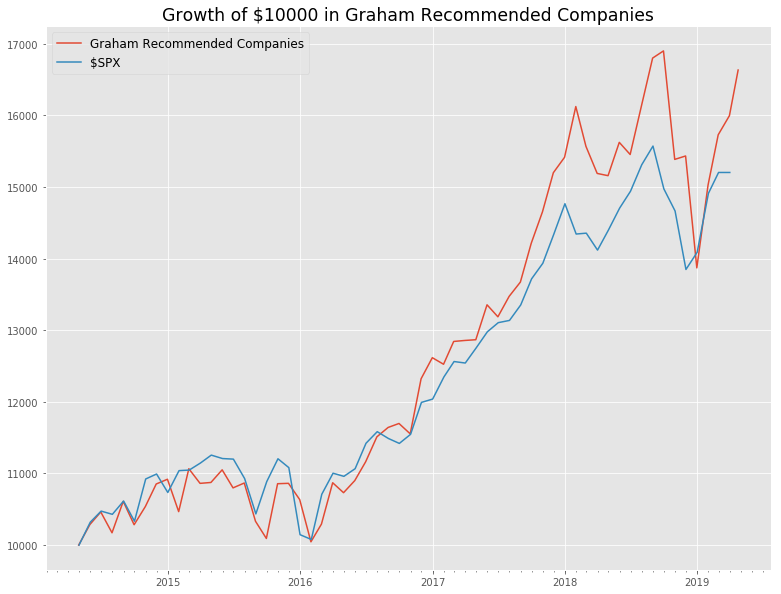

In [256]:
plot_growth(graham_good_scores, '2014-04-17', index='$SPX', title='Graham Recommended Companies')

Your investment of 10000 in this bucket on 2014-04-17 would be worth 14954.57 today
Your investment of 10000 in $SPX on 2014-04-17 would be worth 15200.99 today


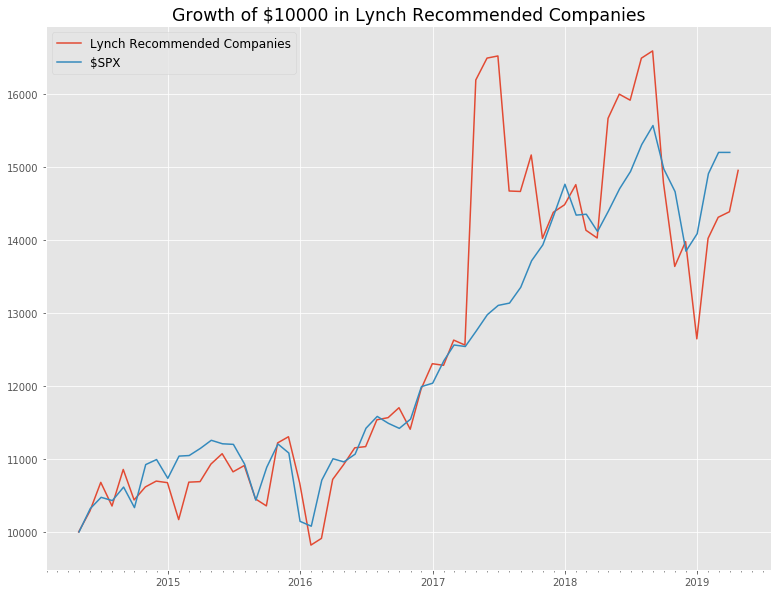

In [257]:
plot_growth(lynch_good_scores, '2014-04-17', index='$SPX', title='Lynch Recommended Companies')